Here, we'll test how dynamically novel the components of the CST- and RTT-unique spaces are.

First, load the data and split the subspaces out:

In [2]:
#| output: false
import src
import pyaldata
import numpy as np
import yaml
import seaborn as sns
import matplotlib.pyplot as plt

with open("../params.yaml", "r") as params_file:
    params = yaml.safe_load(params_file)
load_params = {
    'file_prefix': 'Prez_20220721',
    'preload_params': params['preload'],
    'chop_merge_params': params['chop_merge'],
    'epoch_fun': src.util.generate_realtime_epoch_fun(
        start_point_name='idx_ctHoldTime',
        end_point_name='idx_endTime',
    ),
}

joint_pca_model = src.models.JointSubspace(n_comps_per_cond=20,signal='lfads_rates',condition='task',remove_latent_offsets=False)
dekodec_model = src.models.DekODec(var_cutoff=0.99,signal='lfads_rates_joint_pca',condition='task')
td = (
    src.data.load_clean_data(**load_params)
    .query('task=="RTT" | task=="CST"')
    .assign(**{
        'trialtime': lambda df: df['Time from go cue (s)'],
    })
    .pipe(pyaldata.soft_normalize_signal,signals=['lfads_rates','MC_rates'])
    .pipe(src.data.remove_baseline_rates,signals=['MC_rates','lfads_rates'])
    .pipe(joint_pca_model.fit_transform)
    .pipe(dekodec_model.fit_transform)
)

/Users/raeed/codebase/0-projects/cst-dynamics/src/pyaldata/pyaldata/data_cleaning.py:68: RuntimeWarning: invalid value encountered in cast
  int_arrays = [np.int32(arr) for arr in df[field]]
/Users/raeed/codebase/0-projects/cst-dynamics/env/lib/python3.10/site-packages/pandas/core/series.py:893: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)


Removed 41 trials that monkey aborted
1 trials with high firing rates removed. Dropping trials with IDs:
[294]
M1: 8 correlated units removed
PMd: 0 correlated units removed
MC: 8 correlated units removed
Removed 0 neurons from M1_spikes.
Removed 2 neurons from MC_spikes.
Removed 2 neurons from PMd_spikes.
Optimizing...
                                            f: +2.276893e+04   |grad|: 1.540758e+04
acc TR+   k:     1     num_inner:     0     f: +1.457359e+04   |grad|: 1.296075e+04   negative curvature
acc       k:     2     num_inner:     0     f: +8.574829e+03   |grad|: 6.429266e+03   exceeded trust region
acc TR+   k:     3     num_inner:     1     f: +4.893421e+03   |grad|: 5.452552e+03   exceeded trust region
acc       k:     4     num_inner:     3     f: +2.574496e+03   |grad|: 2.923085e+03   exceeded trust region
acc       k:     5     num_inner:     5     f: +1.602211e+03   |grad|: 2.826087e+03   exceeded trust region
acc TR+   k:     6     num_inner:     6     f: +8.196369e

In [12]:
td.columns

Index(['M1_spikes', 'M1_unit_guide', 'MC_spikes', 'MC_unit_guide',
       'PMd_spikes', 'PMd_unit_guide', 'bin_size', 'cst_cursor_command',
       'ct_location', 'cursor_pos', 'date_time', 'hand_pos', 'idx_cstEndTime',
       'idx_cstStartTime', 'idx_ctHoldTime', 'idx_endTime', 'idx_failTime',
       'idx_goCueTime', 'idx_pretaskHoldTime', 'idx_rewardTime',
       'idx_rtHoldTimes', 'idx_rtgoCueTimes', 'idx_startTime', 'lambda',
       'monkey', 'raw_left_eye_pos', 'raw_left_pupil', 'rel_cursor_pos',
       'rel_hand_pos', 'result', 'rt_locations', 'task', 'trial_id',
       'session_date', 'M1_rates', 'MC_rates', 'PMd_rates', 'lfads_rates',
       'lfads_inputs', 'hand_vel', 'hand_acc', 'cursor_vel', 'hand_speed',
       'Time from go cue (s)', 'Time from task cue (s)', 'trialtime',
       'lfads_rates_joint_pca', 'lfads_rates_joint_pca_cst_unique',
       'lfads_rates_joint_pca_rtt_unique', 'lfads_rates_joint_pca_shared',
       'lfads_rates_joint_pca_split'],
      dtype='object')

Let's double-check that the split worked satisfactorily with a variance plot.

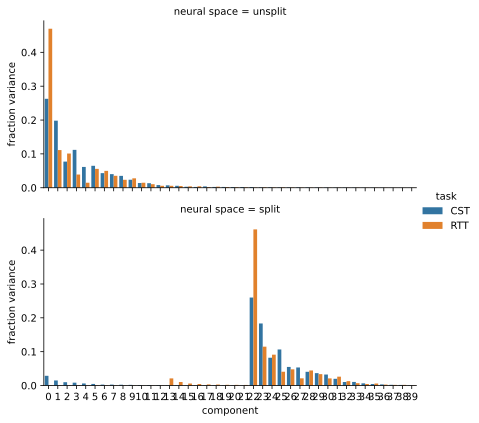

In [3]:
src.plot.plot_split_subspace_variance(td,signal='lfads_rates_joint_pca')

How much of the variance in the unique spaces is explained by correlations with the shared space activity? Let's do a linear regression to find out.

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

signal = 'lfads_rates_joint_pca'
stacked_activity = (
    td
    .groupby('task')
    [[f'{signal}_cst_unique',f'{signal}_rtt_unique',f'{signal}_shared']]
    .agg(np.row_stack)
)

def check_dynamic_commonality(regressor,target):
    model = LinearRegression(fit_intercept=False)
    pred = model.fit(regressor,target).predict(regressor)
    return r2_score(target,pred,multioutput='variance_weighted')

def get_task_shared_unique_activity(task):
    unique_act,shared_act = stacked_activity.loc[task,[f'{signal}_{task.lower()}_unique',f'{signal}_shared']]
    return unique_act,shared_act

def task_shared_commonality(task):
    unique_act,shared_act = get_task_shared_unique_activity(task)
    print(f'{task} unique: {check_dynamic_commonality(shared_act[:,:10],unique_act[:,:6])}')
    print(f'{task} shared: {check_dynamic_commonality(unique_act[:,:6],shared_act[:,:10])}')

task_shared_commonality('CST')
task_shared_commonality('RTT')

CST unique: 0.7345924468044532
CST shared: 0.5361070565372386
RTT unique: 0.7788648489380923
RTT shared: 0.6724883926311015


Seems like there's a good amount of dynamic commonality. Specifically, it looks like the unique spaces, which are lower variance and lower dimensional, are reasonably well explained by the shared space activity during each task (though not fully). This means that there is some projection of the shared space activity during each task that explains most of the unique space activity.

It would be interesting to know whether the potent space of this projection is the same for both tasks, so next, let's check on that.

The way we'll do it is to find the activity in the shared space that explains the unique space activity (the potent space of the linear map between shared and unique activity) and find how much of the total shared space variance that potent space explains. If the potent space is similar between tasks, then each task's potent space should explain a similar amount of the shared space variance.

In [15]:
rtt_unique,rtt_shared = get_task_shared_unique_activity('RTT')
rtt_shared_potent,rtt_shared_null = src.subspace_tools.find_potent_null_space(rtt_shared[:,:10],rtt_unique[:,:6])
cst_unique,cst_shared = get_task_shared_unique_activity('CST')
cst_shared_potent,cst_shared_null = src.subspace_tools.find_potent_null_space(cst_shared[:,:10],cst_unique[:,:6])

rtt_potent_frac_var_rtt = src.subspace_tools.frac_var_explained_by_subspace(rtt_shared[:,:10], rtt_shared_potent)
cst_potent_frac_var_rtt = src.subspace_tools.frac_var_explained_by_subspace(rtt_shared[:,:10], cst_shared_potent)
cst_potent_frac_var_cst = src.subspace_tools.frac_var_explained_by_subspace(cst_shared[:,:10], cst_shared_potent)
rtt_potent_frac_var_cst = src.subspace_tools.frac_var_explained_by_subspace(cst_shared[:,:10], rtt_shared_potent)

print(f'Fraction RTT shared space variance in CST potent space (normalized by RTT potent space var) : {cst_potent_frac_var_rtt/rtt_potent_frac_var_rtt}')
print(f'Fraction CST shared space variance in RTT potent space (normalized by CST potent space var) : {rtt_potent_frac_var_cst/cst_potent_frac_var_cst}')

Fraction RTT shared space variance in CST potent space (normalized by RTT potent space var) : 0.642093238737136
Fraction CST shared space variance in RTT potent space (normalized by CST potent space var) : 0.8733953949032461


array([0.26122831, 0.18428448, 0.08232862, 0.10707485, 0.05501285,
       0.05355403, 0.04062935, 0.03666138, 0.03265566, 0.02001487,
       0.0104445 , 0.01058151, 0.00645572, 0.00447056, 0.00324651,
       0.00217597, 0.00161296, 0.00067247])

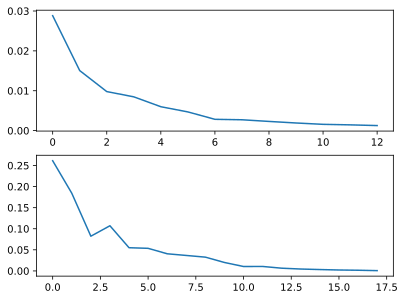

In [29]:
unique_frac_var=np.var(unique_act,axis=0)/np.var(np.column_stack([unique_act,shared_act]),axis=0).sum()
shared_frac_var=np.var(shared_act,axis=0)/np.var(np.column_stack([unique_act,shared_act]),axis=0).sum()
fig,ax = plt.subplots(2,1)
ax[0].plot(unique_frac_var)
ax[1].plot(shared_frac_var)
shared_frac_var